In [11]:
import openpyxl
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# Load the dataset
df = pd.read_excel(r"C:\Users\kamma\Downloads\stocks\ABUK.xlsx")

# Drop rows with NaN values
df.dropna(inplace=True)

# Convert 'Date' column to datetime type (if not already)
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')

# Drop rows where 'Date' could not be parsed properly
df.dropna(subset=['Date'], inplace=True)

# Sort DataFrame by 'Date' column in ascending order
df.sort_values(by='Date', ascending=True, inplace=True)


In [12]:
# Prepare training and test data
train_data = pd.DataFrame(df['Close'][0:int(len(df) * 0.8)])
test_data = pd.DataFrame(df['Close'][int(len(df) * 0.8):int(len(df))])

scaler = MinMaxScaler(feature_range=(0, 1))

train_data_array = scaler.fit_transform(train_data)

x_train = []
y_train = []

for i in range(100, train_data_array.shape[0]):
    x_train.append(train_data_array[i-100:i, 0])
    y_train.append(train_data_array[i, 0])

x_train = np.array(x_train)
y_train = np.array(y_train)

# Reshape for LSTM input
x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], 1))


In [13]:
# Define the LSTM model
model = Sequential([
    LSTM(100, activation='relu', return_sequences=True, input_shape=(x_train.shape[1], 1)),
    Dropout(0.2),
    LSTM(100, activation='relu', return_sequences=True),
    Dropout(0.2),
    LSTM(100, activation='relu'),
    Dropout(0.2),
    Dense(1)
])

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')
# Train the model
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history = model.fit(x_train, y_train, epochs=200, batch_size=32, validation_split=0.2, callbacks=[early_stopping])


Epoch 1/200


C:\Users\kamma\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


98/98 ━━━━━━━━━━━━━━━━━━━━ 12s 90ms/step - loss: 0.0081 - val_loss: 0.0028
Epoch 2/200
98/98 ━━━━━━━━━━━━━━━━━━━━ 8s 81ms/step - loss: 8.3839e-04 - val_loss: 0.0030
Epoch 3/200
98/98 ━━━━━━━━━━━━━━━━━━━━ 8s 80ms/step - loss: 7.0889e-04 - val_loss: 0.0022
Epoch 4/200
98/98 ━━━━━━━━━━━━━━━━━━━━ 8s 80ms/step - loss: 5.9257e-04 - val_loss: 0.0016
Epoch 5/200
98/98 ━━━━━━━━━━━━━━━━━━━━ 8s 85ms/step - loss: 6.2977e-04 - val_loss: 0.0046
Epoch 6/200
98/98 ━━━━━━━━━━━━━━━━━━━━ 8s 83ms/step - loss: 7.6904e-04 - val_loss: 0.0021
Epoch 7/200
98/98 ━━━━━━━━━━━━━━━━━━━━ 8s 80ms/step - loss: 6.3211e-04 - val_loss: 0.0030
Epoch 8/200
98/98 ━━━━━━━━━━━━━━━━━━━━ 8s 82ms/step - loss: 6.3558e-04 - val_loss: 0.0024
Epoch 9/200
98/98 ━━━━━━━━━━━━━━━━━━━━ 9s 88ms/step - loss: 5.4574e-04 - val_loss: 0.0011
Epoch 10/200
98/98 ━━━━━━━━━━━━━━━━━━━━ 9s 88ms/step - loss: 5.9022e-04 - val_loss: 0.0023
Epoch 11/200
98/98 ━━━━━━━━━━━━━━━━━━━━ 9s 88ms/step - loss: 4.9662e-04 - val_loss: 0.0013
Epoch 12/200
98/98 ━━━━

In [18]:
# Scale the test data using the same scaler as the training data
test_data_array = scaler.transform(test_data)

x_test = []
y_test = []

# Create sequences for test data
for i in range(100, test_data_array.shape[0]):
    x_test.append(test_data_array[i-100:i, 0])
    y_test.append(test_data_array[i, 0])

x_test = np.array(x_test)
y_test = np.array(y_test)

# Reshape for LSTM input
x_test = x_test.reshape((x_test.shape[0], x_test.shape[1], 1))

# Make predictions
predictions = model.predict(x_test)

# Reshape predictions to 2D
predictions = predictions.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)

# Ensure lengths match for comparison
length = min(len(y_test), len(predictions))

# Create a DataFrame with predicted and actual values
result_df = pd.DataFrame({
    'Date': df['Date'].iloc[len(df) - len(test_data) + 100:].reset_index(drop=True),
    'Actual Prices': scaler.inverse_transform(y_test[:length]).flatten(),
    'Predicted Prices': scaler.inverse_transform(predictions[:length]).flatten()
})

result_df


29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step


,Date,Actual Prices,Predicted Prices
0,2019-03-27,26.10,27.122139
1,2019-03-28,26.30,27.111492
2,2019-03-31,26.83,27.066605
3,2019-04-01,26.40,27.006977
4,2019-04-02,26.99,26.934816
...,...,...,...
895,2022-12-01,34.95,29.764517
896,2022-12-04,36.45,30.192360
897,2022-12-05,37.00,30.676527
898,2022-12-06,36.52,31.214167


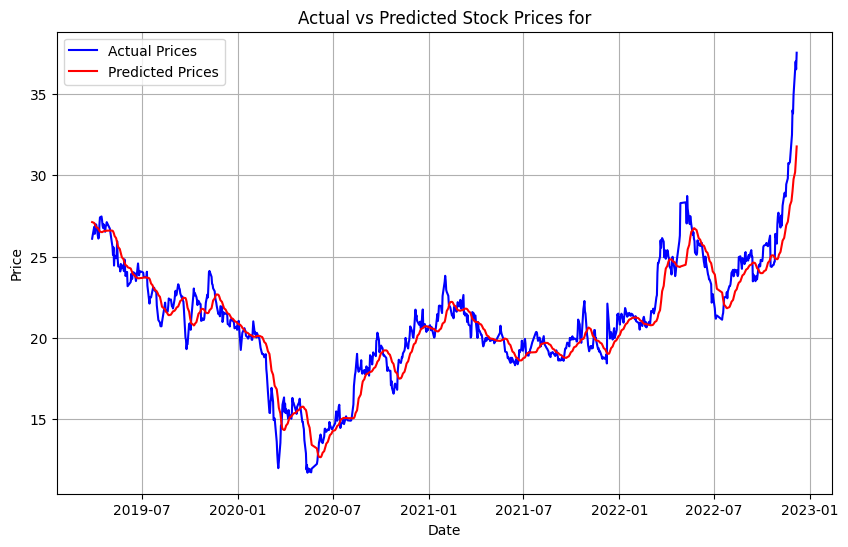

In [19]:
# Plot actual vs predicted prices
plt.figure(figsize=(10, 6))
plt.plot(result_df['Date'], result_df['Actual Prices'], color='blue', label='Actual Prices')
plt.plot(result_df['Date'], result_df['Predicted Prices'], color='red', label='Predicted Prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title(f'Actual vs Predicted Stock Prices for')
plt.legend()
plt.grid(True)
plt.show()


In [20]:
    # Evaluate the model
    mae = mean_absolute_error(y_test, predictions)
    mse = mean_squared_error(y_test, predictions)
    rmse = np.sqrt(mse)
    print(f'Mean Absolute Error on Test Data: {mae}')
    print(f'Mean Squared Error on Test Data: {mse}')
    print(f'Root Mean Squared Error on Test Data: {rmse}')


Mean Absolute Error on Test Data: 0.024872958282085456
Mean Squared Error on Test Data: 0.0012154016456307072
Root Mean Squared Error on Test Data: 0.03486261099847094


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Predicted Price for the next day: 32.35734939575195


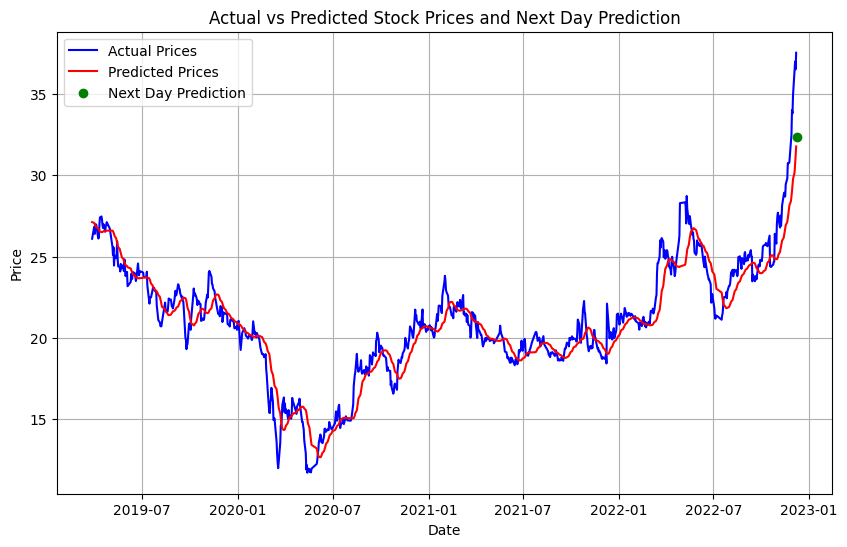

In [21]:
# Prepare the last 100 data points for the next day prediction
last_100_days = test_data_array[-100:]
last_100_days = last_100_days.reshape((1, last_100_days.shape[0], 1))

# Predict the price for the next day
predicted_price_next_day = model.predict(last_100_days)

# Rescale the predicted price back to the original scale
predicted_price_next_day = scaler.inverse_transform(predicted_price_next_day)

print(f'Predicted Price for the next day: {predicted_price_next_day[0][0]}')

# Adding the next day's prediction to the plot
next_day = df['Date'].iloc[-1] + pd.Timedelta(days=1)

plt.figure(figsize=(10, 6))
plt.plot(result_df['Date'], result_df['Actual Prices'], color='blue', label='Actual Prices')
plt.plot(result_df['Date'], result_df['Predicted Prices'], color='red', label='Predicted Prices')
plt.scatter(next_day, predicted_price_next_day, color='green', label='Next Day Prediction', zorder=5)
plt.xlabel('Date')
plt.ylabel('Price')
plt.title(f'Actual vs Predicted Stock Prices and Next Day Prediction')
plt.legend()
plt.grid(True)
plt.show()
